We gonna show how to use BayesTME's `expression_truth` module to get a prior on expression profile from a cell atlas data consisting of gene expression data of thounsands of cells of several cell types from multiple samples, which can be used in deconvolution job.

In [2]:
import os

from bayestme import expression_truth as et
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import numpyro

Load the example atlas data

In [3]:
atlas_data = pd.read_csv("/content/E-MTAB-6653_example.csv", index_col=0)
print('{} samples'.format(len(np.unique(atlas_data.sample_id))))
print('{} cell types'.format(len(np.unique(atlas_data.cell_type))))

3 samples
5 cell types


The example atlas data had 15 cells and 23981 genes of 5 cells from 3 samples 

In [4]:
atlas_data.head()

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000289690,ENSG00000289692,ENSG00000289694,ENSG00000289695,ENSG00000289697,ENSG00000289700,ENSG00000289701,ENSG00000289716,cell_type,sample_id
0,0.000002,0.000042,0.000004,7.423628e-07,0.000100,0.000007,0.000050,0.000015,0.000005,0.000011,...,0.000004,3.247838e-07,0.000105,0.0,9.279536e-08,2.783861e-07,0.000014,1.855907e-07,1,6
1,0.000003,0.000074,0.000008,3.515130e-06,0.000042,0.000017,0.000018,0.000013,0.000009,0.000018,...,0.000003,0.000000e+00,0.000084,0.0,3.515130e-07,5.858550e-07,0.000007,3.515130e-07,2,6
2,0.000003,0.000062,0.000008,4.080497e-06,0.000006,0.000010,0.000009,0.000030,0.000007,0.000018,...,0.000003,0.000000e+00,0.000047,0.0,1.974433e-07,3.948866e-07,0.000005,3.290722e-07,4,6
3,0.000010,0.000053,0.000006,2.750273e-07,0.000008,0.000030,0.000033,0.000005,0.000005,0.000013,...,0.000003,0.000000e+00,0.000043,0.0,1.650164e-06,6.875682e-07,0.000005,1.375136e-07,5,6
4,0.000020,0.000097,0.000016,2.904005e-06,0.000045,0.000035,0.000025,0.000016,0.000007,0.000015,...,0.000005,2.420004e-07,0.000085,0.0,7.260012e-07,9.680016e-07,0.000006,0.000000e+00,6,6


Let's clean up this dataset a bit

In [5]:
atlas_frame = atlas_data.melt(id_vars = ["cell_type", "sample_id"], ignore_index=False)
atlas_frame = atlas_frame.set_index(["sample_id", "cell_type", "variable"])

In [6]:
atlas_frame.head()

value
sample_id cell_type variable                 
6         1         ENSG00000000003  0.000002
          2         ENSG00000000003  0.000003
          4         ENSG00000000003  0.000003
          5         ENSG00000000003  0.000010
          6         ENSG00000000003  0.000020

And prepare the input atlas data for BayesTME, where the atlas data `expression_truth` is 3-dimensional: $n_{\text{sample}}\times n_{\text{celltype}}\times n_{\text{cell}}$ 

In [7]:
shape = [len(x) for x in atlas_frame.index.levels]
arr = np.full(shape, np.nan)
arr[tuple(atlas_frame.index.codes)] = atlas_frame.values.flat
assert np.isnan(arr).sum() == 0


L = np.min(arr[arr > 0])
arr[arr==0] = L/10.0
arr_norm = arr / arr.sum(axis=2)[:, :, None]
assert arr_norm[arr_norm==0].sum() == 0

expression_truth = arr_norm
print(expression_truth.shape)

(3, 5, 23979)


We will use the `dirichlet_alpha_model` to infer the gene expression prior of the Dirichlet model used in BayesTME's deconvolution module

In [8]:
with numpyro.handlers.seed(rng_seed=1):
  trace = numpyro.handlers.trace(et.dirichlet_alpha_model).get_trace(expression_truth[:, 0, :])
print(numpyro.util.format_shapes(trace))

Trace Shapes:              
 Param Sites:              
Sample Sites:              
   alpha dist       |      
        value 23979 |      
      N plate     3 |      
     obs dist     3 | 23979
        value     3 | 23979


In [9]:
alpha = et.combine_multiple_expression_truth(expression_truth)

sample: 100%|██████████| 400/400 [01:22<00:00,  4.86it/s, 63 steps of size 8.18e-02. acc. prob=0.86]


The resulting `alpha` prior is 2-dimensional: $n_{\text{celltype}} \times n_{\text{gene}}$ containing the infered Dirichelt prior for each cell type.
And we can visualize the prior by the following plot:

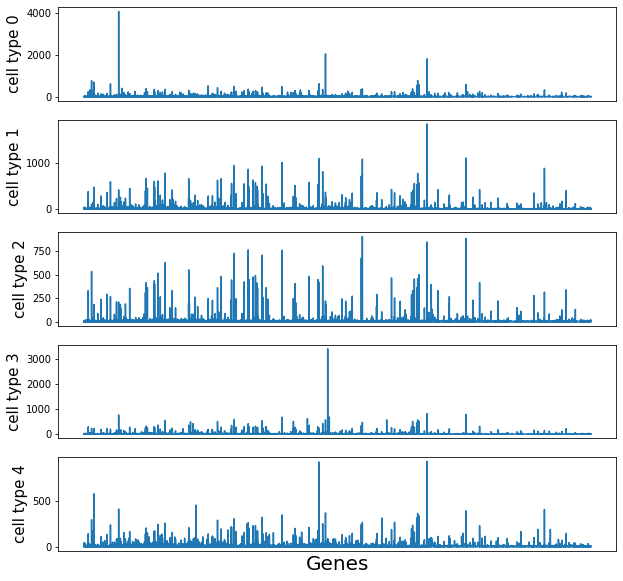

In [10]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
for k in range(5):
    ax[k].plot(np.arange(23979), alpha[k])
    ax[k].set_xticks([])
    ax[k].set_ylabel('cell type {}'.format(k), fontsize=15)
ax[4].set_xlabel('Genes', fontsize=20)
plt.show()

And all these steps in integrated in BayesTME's command line interface, you just need to provide the `--expression-truth` argument multiple times to deconvolve.

For example:
```
deconvolve --expression-truth average_expression_sample_1.csv \
    --expression-truth average_expression_sample_2.csv \
    --expression-truth average_expression_sample_3.csv
```
`deconvolve` will consider all the samples jointly to determine baseline expression profiles for the different cell types.
Detail is avaiable at https://bayestme.readthedocs.io/en/latest/fine_mapping_workflow.html